In [1]:
import tensorflow as tf
import numpy as np
import tsp_env
# from pointer_net_tsp import *
from pointer_net_tsp_cnn import *
from critic_network_tsp import *

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
batch_size = 128; n_coords = 2; n_cities = 5; hidden_size = 128; 
embedding_size = hidden_size
# Define the network and placeholders
cities_coords_ph = tf.placeholder(tf.float32, [batch_size, n_cities, n_coords])
played_actions_ph = tf.placeholder(tf.int32, [batch_size, n_cities])
rewards_ph = tf.placeholder(tf.float32, [batch_size])
adv_ph = tf.placeholder(tf.float32, [batch_size])

# Actor network definition
loss, decoder_outputs, total_loss = pointer_network(cities_coords_ph,
                                                    played_actions_ph,
                                                    hidden_size=hidden_size,
                                                    embedding_size=embedding_size,
                                                    max_time_steps=n_cities,
                                                    input_size=n_coords,
                                                    batch_size=batch_size,
                                                    initialization_stddev=0.1)

# Critic network definition
bsln_value = critic_network(cities_coords_ph,
                            hidden_size=hidden_size,
                            embedding_size=embedding_size,
                            max_time_steps=n_cities,
                            input_size=n_coords,
                            batch_size=batch_size,
                            initialization_stddev=0.1,
                            n_processing_steps=n_cities,
                            d=embedding_size)

# Cross entropy (loss here) is the negative log likelihood of taken actions
# Rewards is negative tour length
# We want to maximize E[logprob(\tau) * reward(\tau)]
# I.e. minimize E[logprob(tau) * tour_length(\tau)]
# I.e. minimize -E[cross entropy(tau) * tour_length(\tau)]
# I.e. minimize E[cross_entropy(\tau) * reward(\tau)] = E[loss(\tau) * reward(\tau)]
pg_loss = tf.reduce_sum(loss * adv_ph)
optimizer = tf.train.AdamOptimizer(2e-3)
update_op = optimizer.minimize(pg_loss)

# Baseline loss and training op
bsln_loss = tf.losses.mean_squared_error(labels=rewards_ph,
                                         predictions=bsln_value)
bsln_train_op = tf.train.AdamOptimizer(2e-3).minimize(bsln_loss)

In [3]:
n_baseline_gradient_steps = 10
mean_approx_ratios = []
#################################
#        POLICY GRADIENT        # 
#################################
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
# Iterate batch collection and gradient steps
for it in range(int(100 * 20)):
    # Collect batch
    envs = []
    inputs_list = []
    # Generate and initialize a batch of environments
    for i in range(batch_size):
        envs.append(tsp_env.TSP_env(n_cities, use_alternative_state=True))
        envs[-1].reset()
        inputs_list.append(envs[-1].nodes)

    inputs_batch = np.array(inputs_list)
    # Use the PointerNet on this test batch and get its predictions
    predicted_outputs = np.array(sess.run(decoder_outputs, 
                                          feed_dict={cities_coords_ph: inputs_batch})).T
    # Compute the rewards corresponding to the predicted tours
    rewards = []
    for i in range(batch_size):
        for action in predicted_outputs[i]:
            envs[i].step(action)
        rewards.append(envs[i].accumulated_reward())
        
    # Carry out baseline training steps
    for bsln_step in range(n_baseline_gradient_steps):
        bsln_loss_val, _ = sess.run([bsln_loss, bsln_train_op], 
                                    feed_dict={cities_coords_ph: inputs_batch,
                                               rewards_ph: rewards})
    
    # Compute baseline value
    bsln = sess.run(bsln_value, feed_dict={cities_coords_ph: inputs_batch})
    
    # Compute normalized advantages
    adv = np.array(rewards) - bsln
    normd_adv = (adv - np.mean(adv)) / np.std(adv)
    
    
    # Print average reward
    if it % 100 == 0:
        print('Mean reward: ', np.mean(rewards))
        print('Baseline MSE: ', bsln_loss_val)
        # Get approximation ratio
        test_envs = []
        test_inputs_list = []
        test_optimal_rewards = []
        test_optimal_tours = []
        # Generate and initialize a batch of environments
        for i in range(batch_size):
            test_envs.append(tsp_env.TSP_env(n_cities, use_alternative_state=True))
            test_envs[-1].reset()
            test_inputs_list.append(test_envs[-1].nodes)
            test_optimal_solution = test_envs[-1].optimal_solution()
            test_optimal_rewards.append(test_optimal_solution[0])
            test_optimal_tours.append(test_optimal_solution[1])
        test_inputs_batch = np.array(test_inputs_list)
        # Use the PointerNet on this test batch and get its predictions
        test_predicted_outputs = np.array(sess.run(decoder_outputs,
                                                   feed_dict={cities_coords_ph: test_inputs_batch})).T
        # Compute the rewards corresponding to the predicted tours
        test_rewards = []
        for k in range(batch_size):
            for test_action in test_predicted_outputs[k]:
                test_envs[k].step(test_action)
            test_rewards.append(test_envs[k].accumulated_reward())
        # Get the approximation ratio of the predictions
        approximation_ratios = np.array(test_rewards) / np.array(test_optimal_rewards)
        mean_approx_ratios.append(np.mean(approximation_ratios))
        print('Mean approx ratio: ', mean_approx_ratios[-1])
    
    # Take a gradient step
    sess.run(update_op, feed_dict={cities_coords_ph: inputs_batch,
                                   played_actions_ph: predicted_outputs,
                                   adv_ph: normd_adv})

Mean reward:  -2.63118504469
Baseline MSE:  0.447038
Mean approx ratio:  1.22205727752
Mean reward:  -2.44070418581
Baseline MSE:  0.0705056
Mean approx ratio:  1.14067852106
Mean reward:  -2.44796928395
Baseline MSE:  0.0351494
Mean approx ratio:  1.1275777566
Mean reward:  -2.39447404604
Baseline MSE:  0.039054
Mean approx ratio:  1.10565639148
Mean reward:  -2.38047431486
Baseline MSE:  0.0356203
Mean approx ratio:  1.10071805783
Mean reward:  -2.44285110153
Baseline MSE:  0.0485424
Mean approx ratio:  1.10248474239
Mean reward:  -2.37843733664
Baseline MSE:  0.0475589
Mean approx ratio:  1.1256594649
Mean reward:  -2.15641648446
Baseline MSE:  0.0166612
Mean approx ratio:  1.03313285501
Mean reward:  -2.21132375081
Baseline MSE:  0.00870712
Mean approx ratio:  1.0213839141
Mean reward:  -2.08940205379
Baseline MSE:  0.00545849
Mean approx ratio:  1.01568887501
Mean reward:  -2.18464757904
Baseline MSE:  0.00753141
Mean approx ratio:  1.01047520539
Mean reward:  -2.20159193477
Basel

KeyboardInterrupt: 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


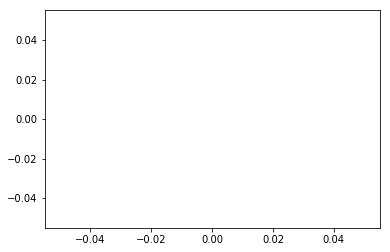

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(mean_approx_ratios)

In [5]:
mean_approx_ratios

[]

In [ ]:
# Sanity check: supervised training
def generate_batch(n_cities, batch_size):
    inputs_list = []; labels_list = []
    env = tsp_env.TSP_env(n_cities, use_alternative_state=True)
    for i in range(batch_size):
        env.reset()
        s = env.reset()
        coords = s.reshape([4, n_cities])[:2, ].T
        inputs_list.append(coords)
        labels_list.append(env.optimal_solution()[1])
    return np.array(inputs_list), np.array(labels_list)

supervised_update_op = tf.train.AdamOptimizer(2e-3).minimize(total_loss)
# Define session, initialize variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
# Training loop
mean_approx_ratios = []
loss_vals = []
for i in range(1000):
    # import pdb; pdb.set_trace()
    inputs_batch, labels_batch = generate_batch(n_cities, batch_size)
    loss_val, _ = sess.run([total_loss, supervised_update_op], 
                         feed_dict={cities_coords_ph: inputs_batch,
                                    played_actions_ph: labels_batch})
    loss_vals.append(loss_val)
    # Test accuracy
    if i % 100 == 0:
        envs = []
        inputs_list = []
        optimal_rewards = []
        optimal_tours = []
        # Generate and initialize a batch of environments
        for i in range(batch_size):
            envs.append(tsp_env.TSP_env(n_cities, use_alternative_state=True))
            envs[-1].reset()
            inputs_list.append(envs[-1].nodes)
            optimal_solution = envs[-1].optimal_solution()
            optimal_rewards.append(optimal_solution[0])
            optimal_tours.append(optimal_solution[1])
        inputs_batch = np.array(inputs_list)
        # Use the PointerNet on this test batch and get its predictions
        predicted_outputs = np.array(sess.run(decoder_outputs, 
                                              feed_dict={cities_coords_ph: inputs_batch})).T
        # Compute the rewards corresponding to the predicted tours
        rewards = []
        for i in range(batch_size):
            for action in predicted_outputs[i]:
                envs[i].step(action)
            rewards.append(envs[i].accumulated_reward())
        # Get the approximation ratio of the predictions
        approximation_ratios = np.array(rewards) / np.array(optimal_rewards)
        mean_approx_ratios.append(np.mean(approximation_ratios))
        print(mean_approx_ratios[-1])
        print(loss_vals[-1])

In [ ]:
inputs_batch[0]

In [ ]:
labels_batch